In [51]:
import pandas as pd
import numpy as np 
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from kmeans_explainer import CFE_explainer
import matplotlib.colors as mcolors
from scipy.io import savemat

import matplotlib.patheffects as path_effects

In [15]:
df = pd.read_csv('output/student_violating_labeled_4.csv')

unfair_clustering_female = df[df['sex']==0]
unfair_clustering_male = df[df['sex']==1]
unfair_clustering_male

female_labels = unfair_clustering_female['unfair_label'].to_numpy()+1
male_labels = unfair_clustering_male['unfair_label'].to_numpy()+1

# Save them to a .mat file
sio.savemat('unfair_clustering_student_4.mat', {
    'female_labels': female_labels,
    'male_labels': male_labels
})


### Cluster alignment

In [16]:
import numpy as np
from collections import defaultdict
from scipy.optimize import linear_sum_assignment

# Jaccard similarity between two clusters
def jaccard_similarity(unfair_cluster, fair_cluster):
    intersection = len(unfair_cluster.intersection(fair_cluster))
    union = len(unfair_cluster.union(fair_cluster))
    return intersection / union if union != 0 else 0

# Build a Jaccard similarity matrix
def compute_similarity_matrix(unfair_clusters, fair_clusters):
    m, n = len(unfair_clusters), len(fair_clusters)
    similarity_matrix = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            similarity_matrix[i, j] = jaccard_similarity(unfair_clusters[i], fair_clusters[j])
    return similarity_matrix

# Align clusters using Hungarian algorithm (minimize 1 - similarity)
def align_clusters(unfair_clusters, fair_clusters):
    similarity_matrix = compute_similarity_matrix(unfair_clusters, fair_clusters)
    cost_matrix = 1 - similarity_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return {i: col_ind[i] for i in range(len(row_ind))}

# Create sets of point indices for each cluster label
def get_cluster_sets(labels):
    clusters = defaultdict(set)
    for idx, label in enumerate(labels):
        clusters[label].add(idx)
    return [clusters[i] for i in sorted(clusters)]


In [17]:
labels_unfair = df["unfair_label"].tolist()
labels_fair = df["fair_label"].tolist()

cluster_A = get_cluster_sets(labels_unfair)  # Unfair clustering
cluster_B = get_cluster_sets(labels_fair)    # Fair clustering

alignment = align_clusters(cluster_A, cluster_B)
print("Cluster alignment:", alignment)

Cluster alignment: {0: 0, 1: 1, 2: 2, 3: 3}


In [18]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment
import numpy as np

labels_orig = labels_unfair
labels_pert = labels_fair

k = len(np.unique(labels_orig))

conf_matrix = np.zeros((k, k), dtype=int)
for i in range(k):
    for j in range(k):
        conf_matrix[i, j] = np.sum((labels_orig == i) & (labels_pert == j))

row_ind, col_ind = linear_sum_assignment(-conf_matrix)
label_map = dict(zip(col_ind, row_ind))

aligned_fair = np.array([label_map[l] for l in labels_pert])

fair_to_unfair = dict(zip(col_ind, row_ind))
unfair_to_fair = dict(zip(row_ind, col_ind))

df['aligned_fair_label'] = df['fair_label'].map(fair_to_unfair)
df['aligned_unfair_label'] = df['unfair_label'].map(unfair_to_fair)


In [19]:
from sklearn.metrics import normalized_mutual_info_score
nmi = normalized_mutual_info_score(labels_unfair, labels_fair)
print(nmi)

0.7505483837921937


In [20]:
# Count points in each unfair cluster
unfair_counts = df["unfair_label"].value_counts().sort_index()

# Count points in each fair cluster
fair_counts = df["fair_label"].value_counts().sort_index()

print("Unfair cluster sizes:")
print(unfair_counts)

print("\nFair cluster sizes:")
print(fair_counts)


Unfair cluster sizes:
unfair_label
0    240
1    185
2     69
3    106
Name: count, dtype: int64

Fair cluster sizes:
fair_label
0    231
1    190
2     68
3    111
Name: count, dtype: int64


In [21]:
from scipy.io import savemat

unfair_centers = np.load(f"output/student_unfair_centers_9.npy")
savemat("output/student_sex_single_unfair_centers_9.mat", {"unfair_centers": unfair_centers})
unfair_centers.shape

(9, 27)

In [22]:

# Exclude non-feature columns (e.g., sensitive attributes + labels)
feature_cols = [col for col in df.columns if col not in ['sex', 'unfair_label',
       'fair_label', 'aligned_fair_label', 'aligned_unfair_label']]

# Group by fair cluster label and compute the mean for each cluster
fair_centers = df.groupby("fair_label")[feature_cols].mean().sort_index().values


### Find misaligned points

In [23]:
misaligned_mask = df["unfair_label"] != df["aligned_fair_label"]

# Get the misaligned points
df_misaligned = df[misaligned_mask]


### Generate counterfactuals

In [24]:


cfes_list = []

# Define mask and epsilon ratio as in your original code
mask = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])  # change according to which features you allow to change
d_eps_center_dist_ratio = 1.0

# Feature columns used for counterfactual generation (adjust as needed)
feature_cols = ['school', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'traveltime', 'studytime', 'failures', 'schoolsup',
       'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
       'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences']

for _, row in df_misaligned.iterrows():
    factual = row[feature_cols].values.astype(float)

    # Get cluster IDs
    source_label = int(row['unfair_label'])
    #print(source_label)
    target_label = int(row['aligned_unfair_label'])
    #print(target_label)

    # Get corresponding centers and slice to match feature_cols
    center_unfair = unfair_centers[source_label][:len(feature_cols)]
    center_fair = fair_centers[target_label][:len(feature_cols)]

    # Generate counterfactual using explainer
    explainer = CFE_explainer(center_unfair, center_fair)
    z_optimal = explainer.compute_counterfactual(factual, mask, d_eps_center_dist_ratio)

    # Optionally: store both factual and counterfactual together
    #combined_row = list(factual) + list(z_optimal)
    cfes_list.append(z_optimal)


In [29]:
cf_feature_cols = [f"cf_{col}" for col in feature_cols]
all_cols = cf_feature_cols
cfes_df = pd.DataFrame(cfes_list, columns=all_cols)
df_combined = df_misaligned.reset_index(drop=True).copy()
df_combined = pd.concat([df_combined, cfes_df], axis=1)

In [30]:
sex_counts = df_misaligned["sex"].value_counts().rename(index={0: "Female", 1: "Male"})
print(sex_counts)


sex
Female    26
Male      24
Name: count, dtype: int64


In [31]:
male_female_per_unfair_cluster = df_misaligned.groupby("unfair_label")["sex"].value_counts().unstack(fill_value=0)
male_female_per_unfair_cluster.columns = ["Female", "Male"]  # Assuming 0 = Female, 1 = Male
print("Per fair cluster:\n", male_female_per_unfair_cluster)


Per fair cluster:
               Female  Male
unfair_label              
0                 13     3
1                 13     0
2                  0     3
3                  0    18


### Males and Females per cluster after the fair clustering

In [32]:
male_female_per_fair_cluster = df.groupby("fair_label")["sex"].value_counts().unstack(fill_value=0)
male_female_per_fair_cluster.columns = ["Female", "Male"]


In [33]:
cf_feature_cols = [f"cf_{col}" for col in feature_cols]
distances = np.sqrt(((df_combined[feature_cols].values - df_combined[cf_feature_cols].values) ** 2).sum(axis=1))
df_combined["euclidean_distance"] = distances
df_combined[["euclidean_distance"] + feature_cols + cf_feature_cols].head()

,euclidean_distance,school,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,cf_higher,cf_internet,cf_romantic,cf_famrel,cf_freetime,cf_goout,cf_Dalc,cf_Walc,cf_health,cf_absences
0,0.352334,-0.731113,-1.464937,-1.515488,-0.654654,0.380839,-1.339702,-1.190630,0.059742,-0.271395,...,0.356173,0.761689,1.325077,-0.881294,-0.076742,0.760269,0.543926,1.335929,0.994220,-0.367246
1,0.080651,-0.731113,1.041609,0.659854,-0.654654,0.380839,1.319023,1.536004,1.652853,-0.271395,...,0.350434,0.556564,-0.764511,0.098584,0.768089,0.680365,1.604202,0.527797,0.999112,-0.794428
2,0.483467,-0.731113,-1.464937,-1.515488,1.527525,0.380839,0.432781,-1.190630,0.059742,-0.271395,...,0.330967,0.263502,-0.784919,0.012528,0.627398,-1.106120,0.520529,0.511279,-0.373526,0.495245
3,0.319902,-0.731113,1.877124,0.659854,-0.654654,0.380839,1.319023,1.536004,-0.736814,-0.271395,...,0.364929,0.571060,-0.767157,-1.976829,-0.169344,0.668186,0.484794,0.491712,-1.093044,-0.374819
4,2.470936,1.367777,-0.629421,-1.515488,1.527525,0.380839,-1.339702,-1.190630,0.856297,0.883478,...,0.271030,-0.921145,1.200689,-0.334984,0.057728,0.152886,0.464891,-0.381694,0.367946,-0.342499


In [34]:
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

change_flags = (df_combined[feature_cols].values != df_combined[cf_feature_cols].values)

change_counts = change_flags.sum(axis=0)
feature_change_frequency = pd.Series(change_counts, index=feature_cols)
feature_change_frequency = feature_change_frequency.sort_values(ascending=False)
print("Feature Change Frequency:\n", feature_change_frequency)


Feature Change Frequency:
 school        50
paid          50
health        50
Walc          50
Dalc          50
goout         50
freetime      50
famrel        50
romantic      50
internet      50
higher        50
nursery       50
activities    50
famsup        50
age           50
schoolsup     50
failures      50
studytime     50
traveltime    50
Fjob          50
Mjob          50
Fedu          50
Medu          50
Pstatus       50
famsize       50
address       50
absences      50
dtype: int32


In [35]:
change_magnitude = np.abs(df_combined[cf_feature_cols].values - df_combined[feature_cols].values)
average_change = change_magnitude.mean(axis=0)
feature_change_magnitude = pd.Series(average_change, index=feature_cols)
feature_change_magnitude = feature_change_magnitude.sort_values(ascending=False)
print("Feature Change Magnitude (Average):\n", feature_change_magnitude)


Feature Change Magnitude (Average):
 schoolsup     0.235073
internet      0.235009
address       0.129884
school        0.122501
paid          0.122481
goout         0.121566
freetime      0.120948
Walc          0.104199
traveltime    0.089199
Fjob          0.086084
Dalc          0.082136
activities    0.076967
famrel        0.075837
Pstatus       0.072837
studytime     0.069691
failures      0.060856
Medu          0.050461
absences      0.047977
age           0.047365
Mjob          0.042610
nursery       0.041907
romantic      0.033585
famsize       0.033523
famsup        0.029980
Fedu          0.029705
higher        0.029686
health        0.015649
dtype: float64


In [36]:
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

changed = df_combined[cf_feature_cols].values != df_combined[feature_cols].values
change_counts = changed.sum(axis=0)

squared_diffs = (df_combined[cf_feature_cols].values - df_combined[feature_cols].values) ** 2
total_dists_squared = squared_diffs.sum(axis=1, keepdims=True)
contributions = np.divide(squared_diffs, total_dists_squared, where=total_dists_squared != 0)

avg_contributions = contributions.mean(axis=0)

feature_summary = pd.DataFrame({
    "Feature": feature_cols,
    "Avg Contribution to Distance": avg_contributions
}).sort_values(by="Avg Contribution to Distance", ascending=False)

feature_summary.reset_index(drop=True, inplace=True)
feature_summary
feature_summary["Avg Contribution (%)"] = feature_summary["Avg Contribution to Distance"] * 100
feature_summary = feature_summary[["Feature", "Avg Contribution (%)"]]
feature_summary
df_combined.to_csv('df_balance_student.csv', index=False)

C:\Users\tania\AppData\Local\Temp\ipykernel_27692\4293404927.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_grouped, x='Sex Label', y='euclidean_distance', palette='Set2')


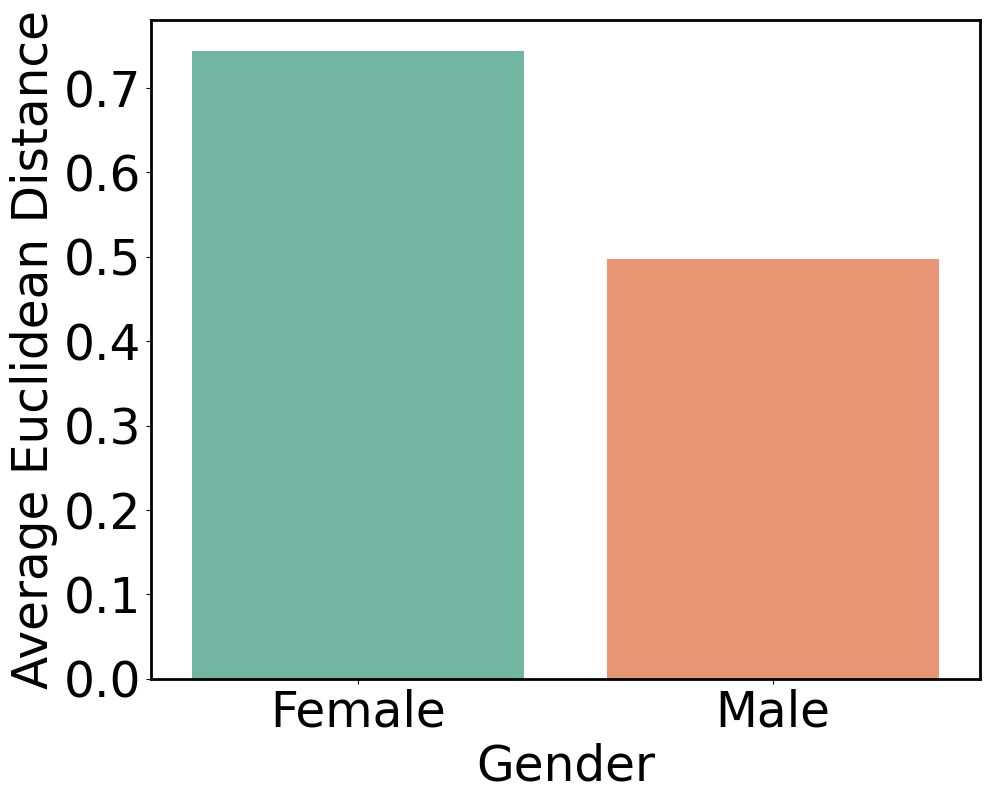

In [38]:
df_combined['Sex Label'] = df_combined['sex'].map({1: 'Male', 0: 'Female'})
df_grouped = df_combined.groupby('Sex Label')['euclidean_distance'].mean().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(data=df_grouped, x='Sex Label', y='euclidean_distance', palette='Set2')

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)    
plt.xlabel("Gender",fontsize=35)
plt.ylabel("Average Euclidean Distance",fontsize=35)
ax = plt.gca()

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()


In [39]:
df_grouped

,Sex Label,euclidean_distance
0,Female,0.743408
1,Male,0.497939


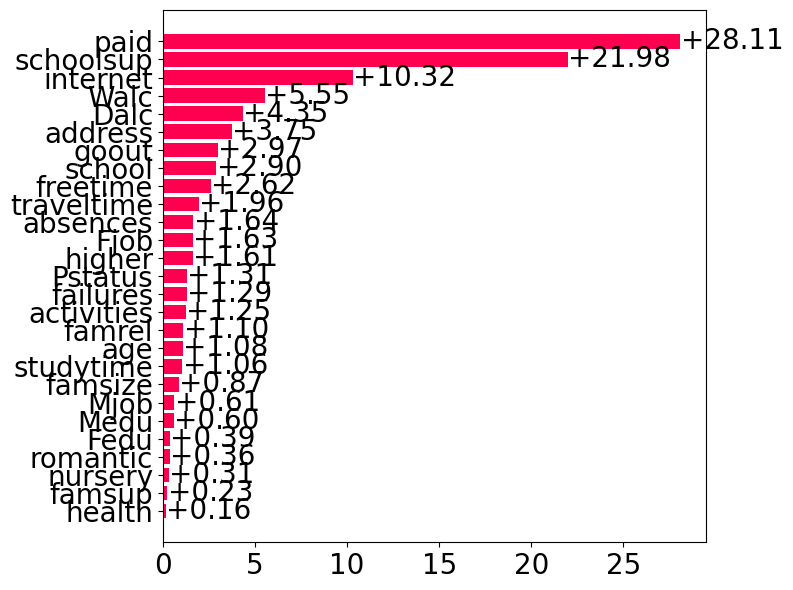

In [40]:
import matplotlib.pyplot as plt

feature_summary = feature_summary.sort_values(by="Avg Contribution (%)", ascending=True)

plt.figure(figsize=(8, 6))
bars = plt.barh(feature_summary["Feature"], feature_summary["Avg Contribution (%)"], color="#FF0051")

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"+{width:.2f}", va='center', fontsize=20)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)    
plt.savefig("feature_contribution_plot_balance_student.pdf", format="pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()


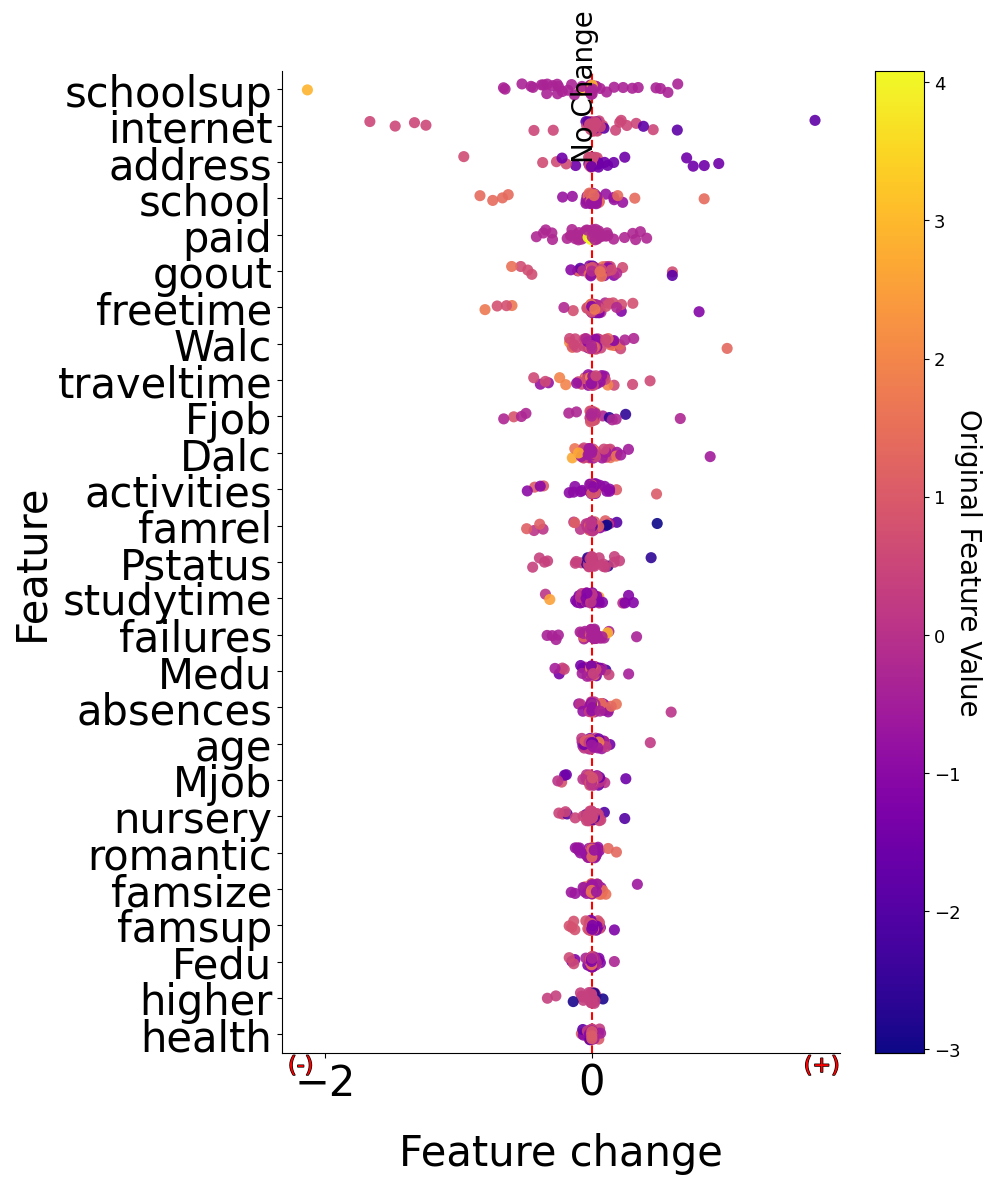

In [42]:
feature_labels = {
    'school': 'School',
    'age': 'Age',
    'address': 'Address',
    'famsize': 'Family Size',
    'Pstatus': 'Parent Status',
    'Medu': 'Mother Education',
    'Fedu': 'Father Education',
    'Mjob': 'Mother Job',
    'Fjob': 'Father Job',
    'traveltime': 'Travel Time',
    'studytime': 'Study Time',
    'failures': 'Failures',
    'schoolsup': 'School Support',
    'famsup': 'Family Support',
    'paid': 'Paid Classes',
    'activities': 'Activities',
    'nursery': 'Attended Nursery',
    'higher': 'Wants Higher Ed.',
    'internet': 'Internet Access',
    'romantic': 'Romantic Relationship',
    'famrel': 'Family Relationship',
    'freetime': 'Free Time',
    'goout': 'Going Out',
    'Dalc': 'Daily Alcohol',
    'Walc': 'Weekend Alcohol',
    'health': 'Health',
    'absences': 'Absences'
}
features = list(feature_labels.keys())
records = []
for feature in features:
    factual_values = df_combined[feature].values
    cf_values = df_combined[f'cf_{feature}'].values
    deltas = cf_values - factual_values

    for f_val, delta in zip(factual_values, deltas):
        records.append({
            'Feature': feature,
            'Delta': delta,
            'FactualValue': f_val
        })

df = pd.DataFrame(records)

feature_order = (
    df.groupby("Feature")["Delta"]
    .apply(lambda x: np.mean(np.abs(x)))
    .sort_values(ascending=False)
    .index
    .tolist()
)

cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=df['FactualValue'].min(), vmax=df['FactualValue'].max())

plt.figure(figsize=(10, 12))
ax = sns.stripplot(
    data=df,
    x='Delta', y='Feature',
    hue='FactualValue',
    palette=cmap,
    dodge=False, jitter=0.15, size=8, alpha=0.9,
    order=feature_order  
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Original Feature Value", rotation=270, labelpad=15, fontsize=20)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel("Feature change", fontsize=30, labelpad=20)
ax.set_ylabel("Feature", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.legend_.remove()

decrease_text = ax.text(df['Delta'].min() - 0.05, ax.get_ylim()[0] + 0.65, '(-)',
                        ha='center', va='bottom', fontsize=16, color='red')
increase_text = ax.text(df['Delta'].max() + 0.05, ax.get_ylim()[0] + 0.65, '(+)',
                        ha='center', va='bottom', fontsize=16, color='red')

for txt in [decrease_text, increase_text]:
    txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                          path_effects.Normal()])

ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.text(-0.05, ax.get_ylim()[1] + 2.5, 'No Change',
        ha='center', va='bottom', fontsize=20, color='black', rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig("explainability_student.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [43]:
df_female = df_combined[df_combined['sex'] == 0]
df_male = df_combined[df_combined['sex'] == 1]


### Explanations of the female

In [44]:
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

# Step 1: Identify which features actually changed
changed = df_female[cf_feature_cols].values != df_female[feature_cols].values
change_counts = changed.sum(axis=0)

# Step 2: Get squared distances per feature
squared_diffs = (df_female[cf_feature_cols].values - df_female[feature_cols].values) ** 2
# Step 3: Normalize contribution by total distance (avoid divide-by-zero)
total_dists_squared = squared_diffs.sum(axis=1, keepdims=True)
contributions = np.divide(squared_diffs, total_dists_squared, where=total_dists_squared != 0)

# Step 4: Average contribution of each feature to total distance
avg_contributions = contributions.mean(axis=0)

# Step 5: Combine into a summary DataFrame
feature_summary = pd.DataFrame({
    "Feature": feature_cols,
    "Avg Contribution to Distance": avg_contributions
}).sort_values(by="Avg Contribution to Distance", ascending=False)

feature_summary.reset_index(drop=True, inplace=True)
feature_summary["Avg Contribution (%)"] = feature_summary["Avg Contribution to Distance"] * 100
feature_summary = feature_summary[["Feature", "Avg Contribution (%)"]]


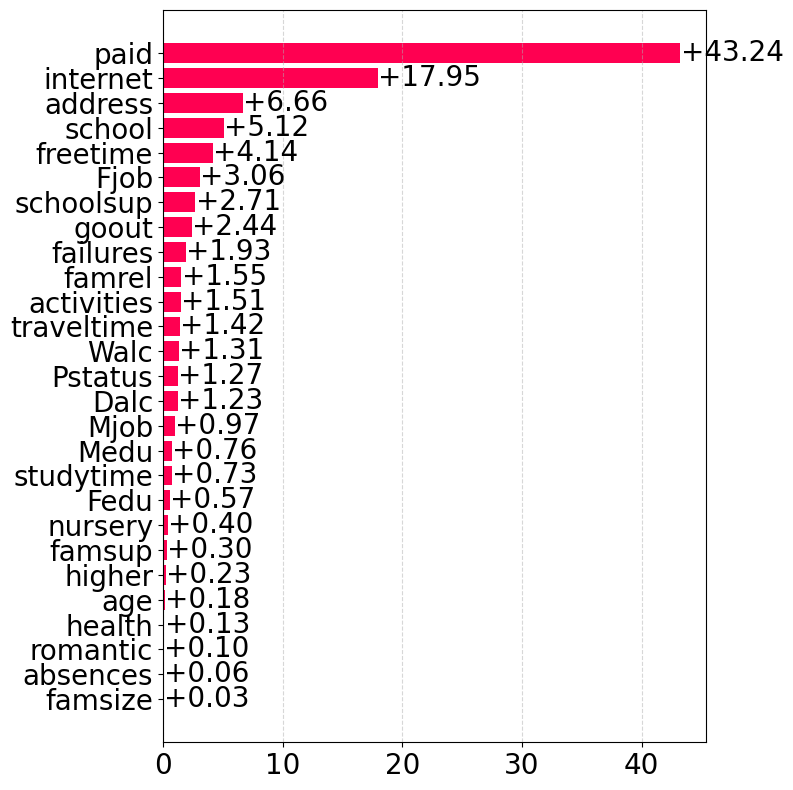

In [45]:
feature_summary = feature_summary.sort_values(by="Avg Contribution (%)", ascending=True)

# Plot
plt.figure(figsize=(8, 8))
bars = plt.barh(feature_summary["Feature"], feature_summary["Avg Contribution (%)"], color="#FF0051")

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"+{width:.2f}", va='center', fontsize=20)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)    
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig("feature_contribution_plot_balance_student_female.pdf", format="pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()


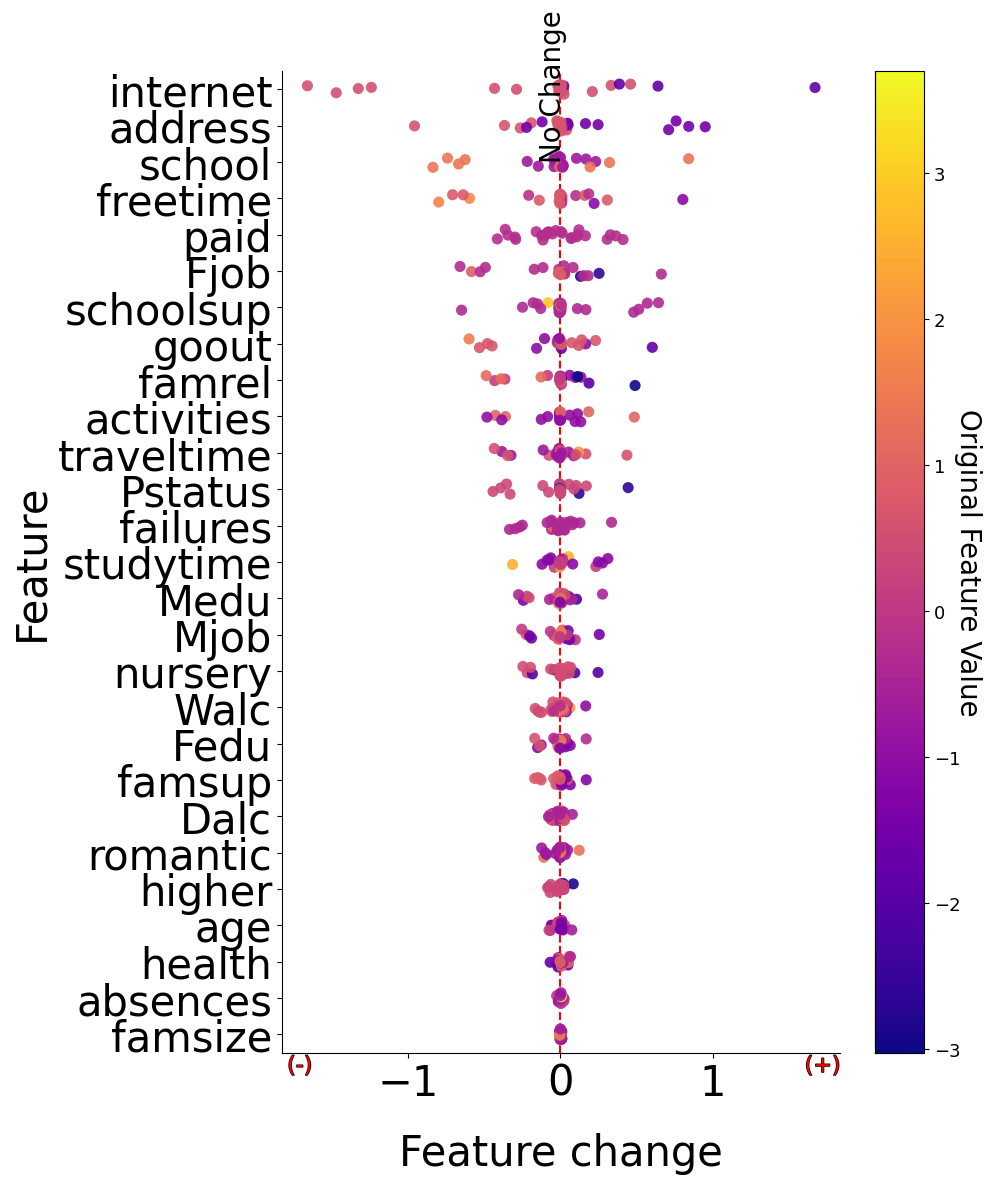

In [46]:
records = []
for feature in features:
    factual_values = df_female[feature].values
    cf_values = df_female[f'cf_{feature}'].values
    deltas = cf_values - factual_values

    for f_val, delta in zip(factual_values, deltas):
        records.append({
            'Feature': feature,
            'Delta': delta,
            'FactualValue': f_val
        })

df = pd.DataFrame(records)

feature_order = (
    df.groupby("Feature")["Delta"]
    .apply(lambda x: np.mean(np.abs(x)))
    .sort_values(ascending=False)
    .index
    .tolist()
)

cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=df['FactualValue'].min(), vmax=df['FactualValue'].max())

plt.figure(figsize=(10, 12))
ax = sns.stripplot(
    data=df,
    x='Delta', y='Feature',
    hue='FactualValue',
    palette=cmap,
    dodge=False, jitter=0.15, size=8, alpha=0.9,
    order=feature_order  # dynamic order
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Original Feature Value", rotation=270, labelpad=15, fontsize=20)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel("Feature change", fontsize=30, labelpad=20)
ax.set_ylabel("Feature", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.legend_.remove()

decrease_text = ax.text(df['Delta'].min() - 0.05, ax.get_ylim()[0] + 0.65, '(-)',
                        ha='center', va='bottom', fontsize=16, color='red')
increase_text = ax.text(df['Delta'].max() + 0.05, ax.get_ylim()[0] + 0.65, '(+)',
                        ha='center', va='bottom', fontsize=16, color='red')

for txt in [decrease_text, increase_text]:
    txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                          path_effects.Normal()])

ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.text(-0.05, ax.get_ylim()[1] + 2.5, 'No Change',
        ha='center', va='bottom', fontsize=20, color='black', rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig("explainability_student_female.pdf", format="pdf", bbox_inches="tight")
plt.show()


### MALE EXPLANATION

In [48]:
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

# Step 1: Identify which features actually changed
changed = df_male[cf_feature_cols].values != df_male[feature_cols].values
change_counts = changed.sum(axis=0)

# Step 2: Get squared distances per feature
squared_diffs = (df_male[cf_feature_cols].values - df_male[feature_cols].values) ** 2
# Step 3: Normalize contribution by total distance (avoid divide-by-zero)
total_dists_squared = squared_diffs.sum(axis=1, keepdims=True)
contributions = np.divide(squared_diffs, total_dists_squared, where=total_dists_squared != 0)

# Step 4: Average contribution of each feature to total distance
avg_contributions = contributions.mean(axis=0)

feature_summary = pd.DataFrame({
    "Feature": feature_cols,
    "Avg Contribution to Distance": avg_contributions
}).sort_values(by="Avg Contribution to Distance", ascending=False)

feature_summary.reset_index(drop=True, inplace=True)
feature_summary["Avg Contribution (%)"] = feature_summary["Avg Contribution to Distance"] * 100
feature_summary = feature_summary[["Feature", "Avg Contribution (%)"]]


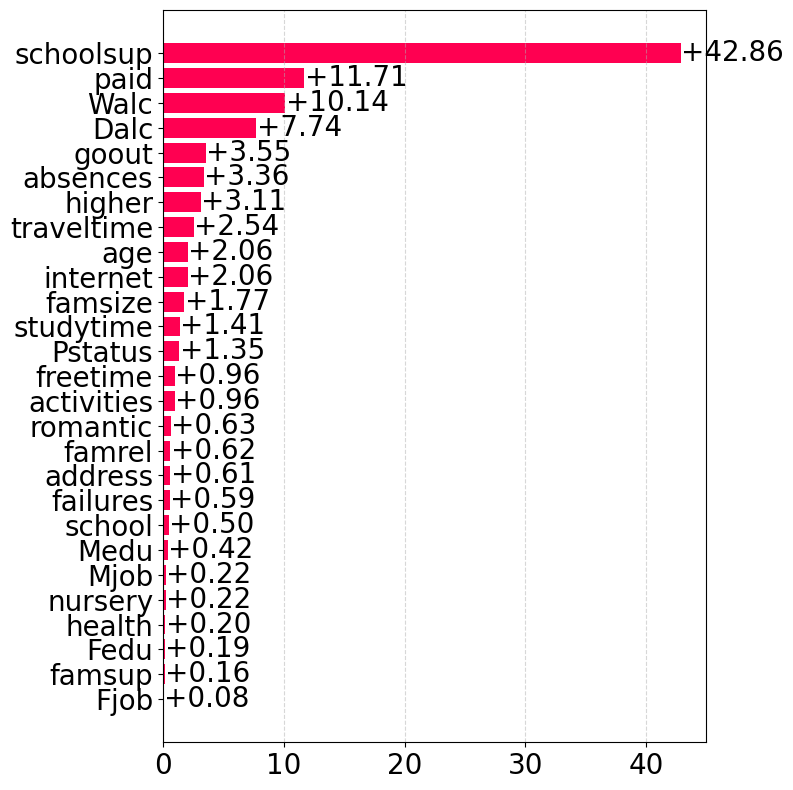

In [49]:
import matplotlib.pyplot as plt

# Sort feature summary again just in case
feature_summary = feature_summary.sort_values(by="Avg Contribution (%)", ascending=True)

# Plot
plt.figure(figsize=(8, 8))
bars = plt.barh(feature_summary["Feature"], feature_summary["Avg Contribution (%)"], color="#FF0051")

# Annotate values like "+0.94"
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"+{width:.2f}", va='center', fontsize=20)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)    
# Style
#plt.title("Feature Contribution to Counterfactual Cost")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig("feature_contribution_plot_balance_student_male.pdf", format="pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()


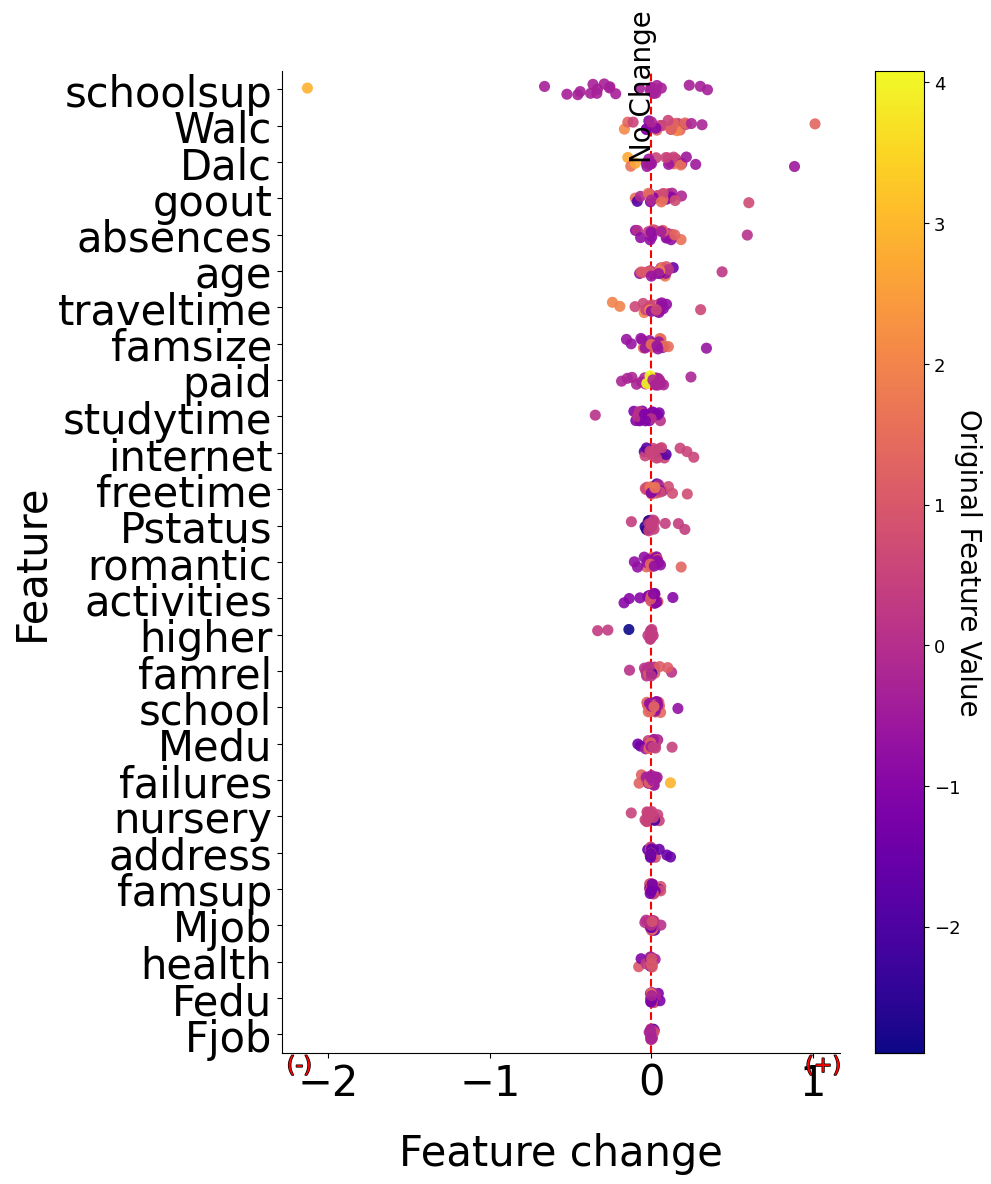

In [50]:
records = []
for feature in features:
    factual_values = df_male[feature].values
    cf_values = df_male[f'cf_{feature}'].values
    deltas = cf_values - factual_values

    for f_val, delta in zip(factual_values, deltas):
        records.append({
            'Feature': feature,
            'Delta': delta,
            'FactualValue': f_val
        })

df = pd.DataFrame(records)

feature_order = (
    df.groupby("Feature")["Delta"]
    .apply(lambda x: np.mean(np.abs(x)))
    .sort_values(ascending=False)
    .index
    .tolist()
)

cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=df['FactualValue'].min(), vmax=df['FactualValue'].max())

plt.figure(figsize=(10, 12))
ax = sns.stripplot(
    data=df,
    x='Delta', y='Feature',
    hue='FactualValue',
    palette=cmap,
    dodge=False, jitter=0.15, size=8, alpha=0.9,
    order=feature_order
)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Original Feature Value", rotation=270, labelpad=15, fontsize=20)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel("Feature change", fontsize=30, labelpad=20)
ax.set_ylabel("Feature", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.legend_.remove()

decrease_text = ax.text(df['Delta'].min() - 0.05, ax.get_ylim()[0] + 0.65, '(-)',
                        ha='center', va='bottom', fontsize=16, color='red')
increase_text = ax.text(df['Delta'].max() + 0.05, ax.get_ylim()[0] + 0.65, '(+)',
                        ha='center', va='bottom', fontsize=16, color='red')

for txt in [decrease_text, increase_text]:
    txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                          path_effects.Normal()])

ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.text(-0.05, ax.get_ylim()[1] + 2.5, 'No Change',
        ha='center', va='bottom', fontsize=20, color='black', rotation=90)
sns.despine()
plt.tight_layout()
plt.savefig("explainability_male.pdf", format="pdf", bbox_inches="tight")
plt.show()
